# Intro

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

shuffles = {
    'train': True,
    'test': True,
    'valid': False
}

data_dir = './faces'
samples = ['train', 'test', 'valid']
image_datasets = { x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x]) for x in samples }
dataloaders = { x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=shuffles[x], num_workers=4) for x in samples }
dataset_sizes = { x: len(image_datasets[x]) for x in samples }
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class_names

['00', '01', '02', '03']

In [3]:
device

device(type='cuda', index=0)

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

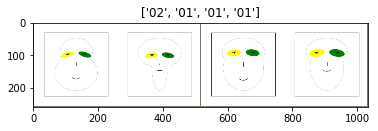

In [5]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

# Train

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
----------
train Loss: 0.4925 Acc: 0.8133
test Loss: 0.5953 Acc: 0.8000

Epoch 1/49
----------
train Loss: 0.2471 Acc: 0.8889
test Loss: 0.4598 Acc: 0.8600

Epoch 2/49
----------
train Loss: 0.2686 Acc: 0.8933
test Loss: 0.5843 Acc: 0.8400

Epoch 3/49
----------
train Loss: 0.1916 Acc: 0.9289
test Loss: 0.5523 Acc: 0.8700

Epoch 4/49
----------
train Loss: 0.1448 Acc: 0.9444
test Loss: 0.4498 Acc: 0.8600

Epoch 5/49
----------
train Loss: 0.0905 Acc: 0.9600
test Loss: 0.6311 Acc: 0.8700

Epoch 6/49
----------
train Loss: 0.0524 Acc: 0.9844
test Loss: 0.4774 Acc: 0.8900

Epoch 7/49
----------
train Loss: 0.0429 Acc: 0.9956
test Loss: 0.4886 Acc: 0.8700

Epoch 8/49
----------
train Loss: 0.0253 Acc: 0.9978
test Loss: 0.4718 Acc: 0.8700

Epoch 9/49
----------
train Loss: 0.0159 Acc: 0.9978
test Loss: 0.5168 Acc: 0.8700

Epoch 10/49
----------
train Loss: 0.0214 Acc: 0.9978
test Loss: 0.5439 Acc: 0.8700

Epoch 11/49
----------
train Loss: 0.0183 Acc: 0.9956
test Loss: 0.5461 Acc

# Validate

In [9]:
def validate_model(model, num_images=6):
    y_true = []
    y_pred = []
    was_training = model.training
    model.eval()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            cpu_labels = labels.cpu().numpy()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                cpu_label = f'{cpu_labels[j]:02}'
                clazz_name = class_names[preds[j]]
                
                y_true.append(cpu_label)
                y_pred.append(clazz_name)
                
                
        model.train(mode=was_training)
    return y_true, y_pred

In [10]:
y_true, y_pred = validate_model(model_ft)

In [11]:
from sklearn.metrics import multilabel_confusion_matrix

cmatrices = multilabel_confusion_matrix(y_true, y_pred, labels=class_names)
for clazz in range(len(cmatrices)):
    cmatrix = cmatrices[clazz]
    tn, fp, fn, tp = cmatrix[0][0], cmatrix[0][1], cmatrix[1][0], cmatrix[1][1]
    sen = tp / (tp + fn)
    spe = tn / (tn + fp)
    acc = (tp + tn) / (tp + fp + fn + tn)
    f1 = (2.0 * tp) / (2 * tp + fp + fn)
    mcc = (tp * tn - fp * fn) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    print('{}: sen = {:.5f}, spe = {:.5f}, acc = {:.5f}, f1 = {:.5f}, mcc = {:.5f}'.format(clazz, sen, spe, acc, f1, mcc))

0: sen = 1.00000, spe = 1.00000, acc = 1.00000, f1 = 1.00000, mcc = 1.00000
1: sen = 1.00000, spe = 0.96000, acc = 0.97000, f1 = 0.94340, mcc = 0.92582
2: sen = 0.76000, spe = 0.94667, acc = 0.90000, f1 = 0.79167, mcc = 0.72712
3: sen = 0.72000, spe = 0.92000, acc = 0.87000, f1 = 0.73469, mcc = 0.64889


In [12]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true, y_pred)

0.87